In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
import math as m
import copy

tfd=tfp.distributions

In [2]:
def draw(base, position = None, ax = None,R = 100):
    ## function to plot the geometry
    if ax == None:
        f,ax=plt.subplots()
        
    if position is not None:

        t = tf.convert_to_tensor(thickness,dtype = tf.float32)

        ps2 = position-t
        
        ps2 = tf.reverse(ps2,[-1])
        
        for i in tf.range(2,Number_para+2): ## lower layer
            base[i].assign([base[i][0],ps2[i-2]])

        for i in tf.range(Number_para+6,2*Number_para+6): ## upper layer
            base[i].assign([base[i][0],position[i-Number_para-6]])

    x = base[:,0]
    z = base[:,1]
    for i in range(base.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'k-')
    x_ = np.linspace(-R,R,10)
    ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
    ax.plot([x[0],x[-1]],[z[0],z[-1]],'k-')
    ax.set_ylim(base[tf.argmin(base[:,1])][1].numpy()-10,5)
    ax.set_xlim(-R,R)
    
    
pi = tf.constant(m.pi) # define PI in Tensorflow form

In [3]:
def draw_MCMC(base,samples,Truth = None,ax = None,R = 70):
    
    if ax == None:
        f,ax=plt.subplots()
    
    if Truth is not None:
        draw(base,Truth,ax = ax, R = R)
            
    x1 = np.linspace(-R,R,Number_para)

    t = tf.convert_to_tensor(thickness,dtype = tf.float32)
    for ps in samples:
        ps2 = ps-t

        ps2 = tf.reverse(ps2,[-1])

        for i in tf.range(2,Number_para+2): ## lower layer
            base[i].assign([base[i][0],ps2[i-2]])

        for i in tf.range(Number_para+6,2*Number_para+6): ## upper layer
            base[i].assign([base[i][0],ps[i-Number_para-6]])

        for i in range(Number_para+5,base.shape[0]-2):
            ax.plot(base[:,0][i:i+2],base[:,1][i:i+2],'r-',alpha = 0.01)
    
    ax.plot(x1,np.zeros(np.shape(x1)),lw = 0.5)# draw a reference line, surface

    ax.set_ylim(base[tf.argmin(base[:,1])][1].numpy()-10,5)
    ax.set_xlim(-R,R)

In [4]:
depth = -20
thickness = 20

corners=np.array([[-200,depth-thickness],
                  [-70,depth-thickness],
                  [70,depth-thickness],# bottom left coner
              [200,depth-thickness], 
              [200,depth], # bottom right coner
              [70, depth], # top right coner
              [-70,depth],# top left coner
              [-200,depth]])
Number_para = 50
obs_N = 50
points = np.empty((2*Number_para+8,2),dtype = np.float32)

points[0] = corners[0]
points[1] = corners[1]

for i in range(6):
    points[Number_para+i] = corners[i]
    
points[-2]=corners[-2]
points[-1]=corners[-1]

np.random.seed(21)

x2 = np.linspace(-70,70,Number_para+2)
x1 = np.linspace(70,-70,Number_para+2)

thickness = 20
y1 = np.random.uniform(-2,-50,Number_para)
y2 = y1-thickness

y1 = list(reversed(y1))

for i in range(2,Number_para+2): ## lower layer
    points[i][1] = y2[i-2]
    points[i][0] = x2[i-1]
    
for i in range(Number_para+6,2*Number_para+6): ## upper layer
    points[i][1] = y1[i-Number_para-6]
    points[i][0] = x1[i-Number_para-5]


(-70, 70)

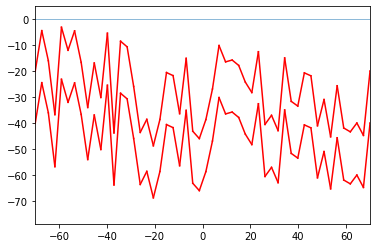

In [5]:
# Draw Base
f,ax=plt.subplots()
x = points[:,0]
z = points[:,1]
for i in range(points.shape[0]):
    ax.plot(x[i:i+2],z[i:i+2],'r-')
x_ = np.linspace(-70,70,10)
ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
ax.plot([x[0],x[-1]],[z[0],z[-1]],'r-')
ax.set_ylim(min(points[:,1])-10,5)
ax.set_xlim(-70,70)

#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [6]:

def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)


def B(x,z,p1,p2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))


def theta(x,z, p):
    if tf.math.not_equal(x[p], 0) :
        if tf.less(tf.atan(tf.divide(z[p],x[p])),0):
            return(tf.atan(tf.divide(z[p],x[p]))+pi)
        else:
            return(tf.atan(tf.divide(z[p],x[p])))
    elif tf.math.logical_and(tf.math.equal(x[p], 0), tf.math.not_equal(z[p], 0)):
        return(pi/2)
    else: return(0.)


def r(x,z,p):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p : int, position
    
    '''
    return(tf.sqrt(x[p]**2+z[p]**2))


def Z(x,z,p1,p2):
    
    if tf.logical_or(tf.logical_and(tf.equal(x[p1],z[p1]),tf.equal(x[p1],0.)), tf.logical_and(tf.equal(x[p2],z[p2]),tf.equal(x[p2],0.))):
        return(0.)

    elif tf.equal(x[p1], x[p2]):
        return((x[p1]*tf.math.log(r(x,z,p2)/r(x,z,p1))))
    
    else:
    
        theta1 = theta(x,z, p1)
        theta2 = theta(x,z, p2)

        r1 = r(x,z,p1)
        r2 = r(x,z,p2)

        _A = A(x,z,p1,p2)
        _B = B(x,z,p1,p2)

        Z_result = _A*((theta1-theta2)+_B*tf.math.log(r1/r2))
        return(Z_result)


def g(data,loc):
    
    ''' 
    data: Points defining the geometry 2N+coners
    loc: reference point (2x1)
    
    '''
    
    G = tf.constant(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = tf.constant(1000.)        # density difference   kg/m^3

    _data = data - loc #Calculate any point refer to the origin

    _x = _data[:,0]
    _z = _data[:,1]

    Z_sum = tf.constant(0.)

    for i in tf.range(_data.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(_x,_z,i,i+1))

    Z_sum = tf.add(Z_sum, Z(_x,_z,-1,0))

    g = 2*G*rho * Z_sum

    return(g)


def grav(points,ps):
    """
    points: base point, fixing the x position
    ps: Positions,Variable(N elements vector), tuning z position
    
    """
    t = tf.convert_to_tensor(thickness,dtype = tf.float32)
    N1 = tf.constant(Number_para)
    ps2 = ps-t

    ps2 = tf.reverse(ps2,[-1])

    for i in tf.range(2,N1+2): ## lower layer
        points[i].assign([points[i][0],ps2[i-2]])

    for i in tf.range(N1+6,2*N1+6): ## upper layer
        points[i].assign([points[i][0],ps[i-N1-6]])

    x_obv = tf.linspace(-70., 70., obs_N+2)
    y_obv = tf.zeros(tf.shape(x_obv))
    obv = tf.stack((x_obv,y_obv),axis = 1)


    gravity = tf.TensorArray(tf.float32, size=obv.shape[0]-2)
    
    j = tf.constant(0)
    for i in obv[1:-1]:
        gravity=gravity.write(j,-g(points,i))
        j = tf.add(j,1)
    return gravity.stack()


def joint_log_prob(D,points_copy,ps):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalFullCovariance(
            loc = mu_prior,
            covariance_matrix= cov_prior)
    # define likelihood
    
    Gm_ = grav(points_copy,ps)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm_,
            covariance_matrix= cov)
    
    # return the posterior probability
    return(mvn_prior.log_prob(ps)
          +mvn_likelihood.log_prob(D))


Define the Prior and likelihood distribution

In [50]:
# prior
mu_prior = -20.*tf.ones([Number_para],dtype = tf.float32)
cov_prior = 20.*tf.eye(Number_para)

# likelihood
sig_e = 0.0000001
cov = sig_e**2*tf.eye(obs_N)

In [51]:
points = tf.Variable(points,dtype = tf.float32)

In [52]:
# define the ground truth
tf.random.set_seed(1234)
tf.random.uniform([Number_para])
True_position = tf.random.uniform([Number_para],-30,-1,seed = 10)
obs_data = grav(points,True_position)

In [53]:
D = obs_data

In [54]:
D

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([7.5347557e-06, 7.6035763e-06, 7.6436881e-06, 7.6689848e-06,
       7.6755787e-06, 7.6385968e-06, 7.5650173e-06, 7.4872437e-06,
       7.4231516e-06, 7.3707970e-06, 7.3245947e-06, 7.2892985e-06,
       7.2740945e-06, 7.2839098e-06, 7.3184824e-06, 7.3736924e-06,
       7.4428372e-06, 7.5176386e-06, 7.5902572e-06, 7.6503502e-06,
       7.6906690e-06, 7.7293871e-06, 7.7813011e-06, 7.8486546e-06,
       7.9329047e-06, 8.0366217e-06, 8.1579738e-06, 8.2825200e-06,
       8.3943714e-06, 8.4804597e-06, 8.4792273e-06, 8.5413640e-06,
       8.7112030e-06, 8.8684801e-06, 8.8680708e-06, 8.8990046e-06,
       8.7795552e-06, 8.5777046e-06, 8.3934628e-06, 8.1993585e-06,
       8.0200407e-06, 7.8709263e-06, 7.7555715e-06, 7.6818305e-06,
       7.6535725e-06, 7.6616661e-06, 7.6807482e-06, 7.6832393e-06,
       7.6609967e-06, 7.6128995e-06], dtype=float32)>

#### create some noise

In [55]:
tf.random.set_seed(1234)
noise = tf.random.normal([obs_N],mean =0,stddev =sig_e,seed = 1)

In [56]:
D_noise = D+noise

In [11]:
joint_log_prob(D,points,True_position)

<tf.Tensor: shape=(), dtype=float32, numpy=426.72443>

In [37]:
def grav_calculate(points_,x=None, R=70,ax = None,style = None,**args):
    if ax is None:
        f,ax=plt.subplots()
    if x is None:
        x = np.linspace(-R,R,501)
    y = np.zeros(np.shape(x))
    obv = np.vstack((x,y)).T
    gravity = []
    for i in obv:
        gravity.append(-g(points_,i))
    gravity = np.array(gravity)
    if style is None:
        style = '-'
    ax.plot(x,gravity,style,**args)
    return gravity

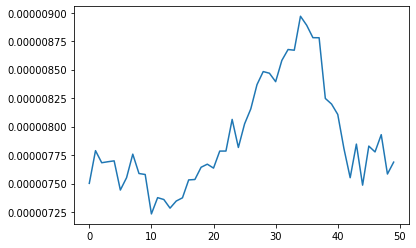

In [57]:
plt.plot(D_noise)

array([7.4581171e-06, 7.5347557e-06, 7.6035763e-06, 7.6436881e-06,
       7.6689848e-06, 7.6755787e-06, 7.6385968e-06, 7.5650173e-06,
       7.4872437e-06, 7.4231516e-06, 7.3707970e-06, 7.3245947e-06,
       7.2892985e-06, 7.2740945e-06, 7.2839098e-06, 7.3184824e-06,
       7.3736924e-06, 7.4428372e-06, 7.5176386e-06, 7.5902572e-06,
       7.6503502e-06, 7.6906690e-06, 7.7293871e-06, 7.7813011e-06,
       7.8486546e-06, 7.9329047e-06, 8.0366217e-06, 8.1579738e-06,
       8.2825200e-06, 8.3943714e-06, 8.4804597e-06, 8.4792273e-06,
       8.5413640e-06, 8.7112030e-06, 8.8684801e-06, 8.8680708e-06,
       8.8990046e-06, 8.7795552e-06, 8.5777046e-06, 8.3934628e-06,
       8.1993585e-06, 8.0200407e-06, 7.8709263e-06, 7.7555715e-06,
       7.6818305e-06, 7.6535725e-06, 7.6616661e-06, 7.6807482e-06,
       7.6832393e-06, 7.6609967e-06, 7.6128995e-06, 7.5389521e-06],
      dtype=float32)

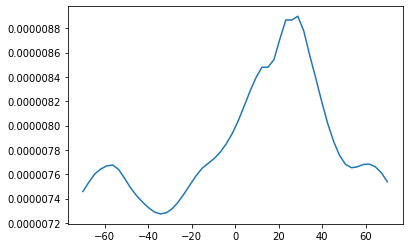

In [38]:
grav_calculate(points,x = tf.linspace(-70., 70., obs_N+2),R = 70)

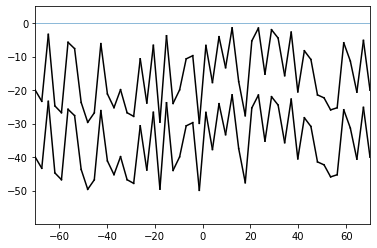

In [40]:
draw(points,position=True_position,R = 70)

In [12]:
True_position

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([ -5.1785946, -20.606672 , -11.302174 ,  -5.881212 , -25.273802 ,
       -25.910046 , -22.322052 , -21.430578 , -10.866999 ,  -8.264807 ,
       -20.506378 ,  -2.7172203, -15.685033 ,  -4.4548607,  -1.9767189,
       -15.243669 ,  -1.4924355,  -5.306797 , -27.638058 , -17.484085 ,
        -1.4281998, -13.29978  ,  -4.0646133, -17.730865 ,  -6.6842613,
       -29.919191 ,  -9.722929 , -10.675497 , -19.930891 , -23.981983 ,
        -3.7785053, -29.56805  ,  -6.642231 , -23.847294 , -10.673523 ,
       -27.841599 , -26.760345 , -19.875717 , -25.240387 , -21.150068 ,
        -6.138069 , -26.8024   , -29.624378 , -23.675385 ,  -7.6183796,
        -5.7310066, -26.752445 , -24.728394 ,  -3.3791924, -23.340313 ],
      dtype=float32)>

#### Gradient decent

In [61]:
mu = tf.random.uniform([Number_para],minval = -20,maxval = -2,seed = 1) # initial parameters

In [63]:
for i in range(2000):
    with tf.GradientTape() as t:  
        t.watch(points)
        loss = tf.negative(joint_log_prob(D_noise,points,mu)) # negative log posterior
        dlossdmu = t.gradient(loss,points)
        dloss = tf.TensorArray(tf.float32, size=Number_para)
        for k,j in enumerate(range(Number_para+6,2*Number_para+6)):
            dloss=dloss.write(k,dlossdmu[j][1])
        d = dloss.stack()   
    mu = mu-0.01*d
    print(i,mu)

0 tf.Tensor(
[ -4.9370804  -4.180999   -8.816688   -8.098028   -9.713776  -18.225592
 -13.178529  -10.922072   -9.365183   -5.4991975 -13.29584    -9.917839
 -17.579975   -7.7006025  -7.7376027 -15.094918   -3.7925723 -19.266586
  -9.236024   -6.279441   -8.324443   -2.8493676  -4.581191   -3.329974
  -6.626276  -14.401937  -15.445285   -4.6819735 -15.737631  -13.199975
  -8.446495   -9.958441  -11.652903  -18.107553   -7.6587434  -5.0034304
 -16.77063   -10.878317  -14.138836  -14.4349785  -7.55005    -9.999153
  -4.2570415 -12.323498  -16.116316   -5.7591457 -11.590502  -16.977846
  -3.824167  -15.369874 ], shape=(50,), dtype=float32)
1 tf.Tensor(
[ -5.0299416  -4.302076   -8.923955   -8.204785   -9.807436  -18.293783
 -13.247098  -10.9881     -9.419118   -5.530737  -13.3039055  -9.906219
 -17.56928    -7.631637   -7.6609945 -15.058459   -3.728346  -19.276667
  -9.2531185  -6.321987   -8.408152   -2.9948635  -4.7588553  -3.5263124
  -6.7920637 -14.53808   -15.583657   -4.832695  -15.

13 tf.Tensor(
[ -5.9806895  -5.5156956 -10.033264   -9.327735  -10.812897  -19.044449
 -14.015806  -11.747176  -10.070977   -5.9623995 -13.461259   -9.843424
 -17.492025   -6.901754   -6.8338313 -14.673899   -3.0526404 -19.379717
  -9.431482   -6.7473     -9.206468   -4.3122964  -6.343129   -5.282977
  -8.333906  -15.843274  -16.919641   -6.29583   -17.3207    -14.861119
 -10.244624  -11.849092  -13.576416  -20.020386   -9.987507   -7.536133
 -18.925074  -13.140541  -16.314621  -16.606812   -9.935212  -12.318939
  -6.601633  -14.251254  -17.801603   -7.482184  -13.035235  -18.193378
  -4.8388367 -16.298687 ], shape=(50,), dtype=float32)
14 tf.Tensor(
[ -6.0485926  -5.600791  -10.113102   -9.409682  -10.88756   -19.101402
 -14.0749855 -11.80676   -10.124072   -6.0005145 -13.477638   -9.842866
 -17.488735   -6.8476396  -6.7713923 -14.64563    -3.0033665 -19.387102
  -9.444543   -6.777092   -9.259897   -4.3965816  -6.4431677  -5.3940487
  -8.434192  -15.930212  -17.009012   -6.393765  -17

26 tf.Tensor(
[ -6.760595   -6.4825706 -10.953764  -10.279994  -11.689725  -19.72231
 -14.726199  -12.470365  -10.728954   -6.4552383 -13.689794   -9.868568
 -17.471828   -6.2586837  -6.083652  -14.342923   -2.4839673 -19.465538
  -9.585432   -7.0864854  -9.795573   -5.21841    -7.410651   -6.4668245
  -9.413971  -16.789537  -17.892908   -7.3579745 -18.369125  -15.962
 -11.433961  -13.10163   -14.854055  -21.292818  -11.523016   -9.200563
 -20.3533    -14.640733  -17.758322  -18.0451    -11.502718  -13.838369
  -8.128558  -15.526877  -18.929585   -8.633741  -14.013796  -19.0262
  -5.5439396 -16.943724 ], shape=(50,), dtype=float32)
27 tf.Tensor(
[ -6.8124294  -6.5460835 -11.015199  -10.344083  -11.749426  -19.769138
 -14.775719  -12.521354  -10.776325   -6.4921856 -13.708106   -9.872697
 -17.471848   -6.2140155  -6.030968  -14.320469   -2.4462647 -19.471373
  -9.596042   -7.108875   -9.832933   -5.274194   -7.4757714  -6.53886
  -9.480316  -16.848293  -17.95331    -7.423394  -18.43417 

39 tf.Tensor(
[ -7.3618975  -7.2142935 -11.66833   -11.0292845 -12.39276   -20.278744
 -15.317872  -13.083737  -11.305786   -6.9154844 -13.926353   -9.935639
 -17.48262    -5.721377   -5.446692  -14.079985   -2.0537379 -19.535456
  -9.712874   -7.346529  -10.216732   -5.835454   -8.12643    -7.2563596
 -10.142877  -17.437977  -18.558361   -8.072658  -19.085018  -16.713966
 -12.242403  -13.958782  -15.735959  -22.176462  -12.588621  -10.358061
 -21.349741  -15.6892805 -18.767607  -19.049582  -12.593614  -14.892545
  -9.182921  -16.413973  -19.71742    -9.433529  -14.698199  -19.611994
  -6.037391  -17.39976  ], shape=(50,), dtype=float32)
40 tf.Tensor(
[ -7.4022684  -7.2630463 -11.716466  -11.080062  -12.440798  -20.31715
 -15.358966  -13.1266575 -11.346679   -6.948885  -13.944156   -9.94167
 -17.484188   -5.6836143  -5.401734  -14.0622     -2.025732  -19.54039
  -9.721845   -7.364083  -10.244102   -5.8746257  -8.171498   -7.3058634
 -10.188625  -17.478851  -18.60018    -8.116997  -19.1

52 tf.Tensor(
[ -7.8325734  -7.780042  -12.231149  -11.625446  -12.960013  -20.735313
 -15.808457  -13.59867   -11.800471   -7.3253446 -14.1496725 -10.0184355
 -17.507807   -5.264558   -4.9026203 -13.872882   -1.7402846 -19.5961
  -9.82202    -7.5532084 -10.52956    -6.2757206  -8.6298485  -7.8072667
 -10.651019  -17.892529  -19.021866   -8.558009  -19.58195   -17.236237
 -12.800109  -14.556769  -16.359503  -22.807127  -13.35245   -11.19229
 -22.068205  -16.447613  -19.497358  -19.775274  -13.3804455 -15.649964
  -9.936384  -17.049686  -20.282372  -10.002271  -15.186491  -20.030773
  -6.3836617 -17.725515 ], shape=(50,), dtype=float32)
53 tf.Tensor(
[ -7.8643346  -7.818018  -12.269275  -11.6660385 -12.998901  -20.766857
 -15.84252   -13.634627  -11.835334   -7.354675  -14.166029  -10.025035
 -17.510069   -5.232281   -4.864224  -13.858989   -1.7204502 -19.600496
  -9.829805   -7.5673738 -10.55021    -6.3041716  -8.66212    -7.842401
 -10.683298  -17.921415  -19.051174   -8.588136  -19.6

65 tf.Tensor(
[ -8.203761   -8.222362  -12.678325  -12.103463  -13.420292  -21.110668
 -16.21529   -14.029901  -12.221188   -7.6827526 -14.351917  -10.104098
 -17.538982   -4.8731933  -4.438699  -13.712324   -1.5241832 -19.650951
  -9.91744    -7.7215295 -10.767836   -6.598746   -8.993997   -8.202036
 -11.011866  -18.215036  -19.347435   -8.88681   -19.929186  -17.601543
 -13.186696  -14.978213  -16.80725   -23.265795  -13.912777  -11.8093405
 -22.598705  -17.009876  -20.038015  -20.312437  -13.962517  -16.207487
 -10.487271  -17.51452   -20.694664  -10.412665  -15.53909   -20.332947
  -6.625587  -17.959183 ], shape=(50,), dtype=float32)
66 tf.Tensor(
[ -8.228865   -8.252162  -12.708717  -12.136119  -13.451932  -21.136633
 -16.24356   -14.060013  -12.250774   -7.7081556 -14.366518  -10.110591
 -17.54148    -4.8454843  -4.406044  -13.701658   -1.5110418 -19.654982
  -9.924292   -7.73318   -10.783733   -6.6198597  -9.0176115  -8.227491
 -11.03495   -18.235611  -19.368053   -8.907093  -19

78 tf.Tensor(
[ -8.497349   -8.569997  -13.035429  -12.488797  -13.795484  -21.419975
 -16.553238  -14.391213  -12.577979   -7.9912033 -14.530942  -10.186029
 -17.571468   -4.5370274  -4.0453086 -13.589974   -1.3863515 -19.701447
 -10.001607   -7.860767  -10.952491   -6.8401     -9.262332   -8.489988
 -11.270904  -18.445019  -19.576284   -9.106314  -20.17148   -17.85687
 -13.453608  -15.276225  -17.132013  -23.60404   -14.331379  -12.27539
 -22.997883  -17.435163  -20.446398  -20.717714  -14.401682  -16.625458
 -10.896739  -17.85934   -20.999228  -10.711354  -15.795366  -20.551857
  -6.792398  -18.126574 ], shape=(50,), dtype=float32)
79 tf.Tensor(
[ -8.517209   -8.593447  -13.059743  -12.51518   -13.82133   -21.441399
 -16.576748  -14.416464  -12.603059   -8.013049  -14.543753  -10.192066
 -17.573933   -4.5132213  -4.017729  -13.581921   -1.3784586 -19.705164
 -10.007659   -7.870462  -10.964903   -6.855997   -9.279875   -8.508704
 -11.287543  -18.4597    -19.590742   -9.119661  -20.18

91 tf.Tensor(
[ -8.729476   -8.843527  -13.321317  -12.80052   -14.102416  -21.675417
 -16.83456   -14.694448  -12.880436   -8.255936  -14.687117  -10.260844
 -17.60249    -4.2483134  -3.7142925 -13.498175   -1.3085855 -19.747917
 -10.075895   -7.9770045 -11.097326   -7.0226707  -9.462708   -8.702824
 -11.458008  -18.608952  -19.736147   -9.248416  -20.338991  -18.03384
 -13.635434  -15.486397  -17.369068  -23.856232  -14.64904   -12.633905
 -23.303158  -17.762453  -20.76004   -21.028488  -14.738556  -16.943508
 -11.204945  -18.117914  -21.226158  -10.929605  -15.982005  -20.710344
  -6.9045205 -18.245659 ], shape=(50,), dtype=float32)
92 tf.Tensor(
[ -8.745159   -8.861964  -13.340792  -12.821892  -14.123594  -21.693129
 -16.854155  -14.715663  -12.901702   -8.274647  -14.698221  -10.26625
 -17.604761   -4.227882   -3.6911983 -13.492177   -1.3046093 -19.751322
 -10.081227   -7.985124  -11.107113   -7.0347605  -9.47589    -8.716747
 -11.470053  -18.619392  -19.746181   -9.256825  -20.34

104 tf.Tensor(
[ -8.912435   -9.058292  -13.550291  -13.053235  -14.354202  -21.886774
 -17.069263  -14.949487  -13.137029   -8.482432  -14.821905  -10.326917
 -17.63038    -4.000726   -3.4383194 -13.430135   -1.2746899 -19.790247
 -10.141202   -8.074519  -11.211901   -7.1619782  -9.613922   -8.861922
 -11.593602  -18.725178  -19.846273   -9.335279  -20.45264   -18.15436
 -13.756121  -15.633303  -17.54273   -24.04602   -14.89362   -12.91447
 -23.540142  -18.018373  -21.004622  -21.270329  -15.000815  -17.188662
 -11.439259  -18.313442  -21.396261  -11.089066  -16.117624  -20.824463
  -6.9765143 -18.329203 ], shape=(50,), dtype=float32)
105 tf.Tensor(
[ -8.924761   -9.072735  -13.565883  -13.070576  -14.371599  -21.901443
 -17.085632  -14.967354  -13.155084   -8.498424  -14.831442  -10.331615
 -17.632366   -3.9832253  -3.4191742 -13.425713   -1.2734957 -19.793325
 -10.145875   -8.081342  -11.219671   -7.171239   -9.623922   -8.8723955
 -11.602342  -18.732542  -19.853106   -9.340157  -20

117 tf.Tensor(
[ -9.055806   -9.226049  -13.733463  -13.258335  -14.561207  -22.061943
 -17.265512  -15.164515  -13.355027   -8.675863  -14.937227  -10.383652
 -17.654171   -3.7888367  -3.2106128 -13.380076   -1.2712693 -19.82825
 -10.198255   -8.156523  -11.30309    -7.268954   -9.729112   -8.982191
 -11.692044  -18.806702  -19.920328   -9.382613  -20.527258  -18.23395
 -13.8325815 -15.734278  -17.670128  -24.190062  -15.0846195 -13.137735
 -23.726797  -18.221598  -21.198141  -21.46116   -15.207825  -17.379837
 -11.61885   -18.46228   -21.52427   -11.2050705 -16.215487  -20.905722
  -7.018923  -18.386436 ], shape=(50,), dtype=float32)
118 tf.Tensor(
[ -9.065424   -9.237284  -13.745919  -13.272412  -14.575524  -22.074112
 -17.279215  -15.1796    -13.370381   -8.68951   -14.94535   -10.387627
 -17.655813   -3.7738738  -3.1949108 -13.376828   -1.271951  -19.830992
 -10.202321   -8.162264  -11.309292   -7.276086   -9.73677    -8.990161
 -11.698394  -18.811823  -19.924833   -9.384963  -20.

130 tf.Tensor(
[ -9.167188   -9.355981  -13.879584  -13.424826  -14.7317095 -22.207348
 -17.429987  -15.346302  -13.540601   -8.840895  -15.035123  -10.4310665
 -17.673357   -3.6078038  -3.0248296 -13.343272   -1.2879387 -19.861832
 -10.247751   -8.225552  -11.376007   -7.35151    -9.817694   -9.074256
 -11.763611  -18.86291   -19.968157   -9.401706  -20.573511  -18.28375
 -13.876946  -15.801727  -17.76353   -24.300272  -15.235934  -13.318393
 -23.875935  -18.385443  -21.35347   -21.613808  -15.373403  -17.530544
 -11.757414  -18.57616   -21.620792  -11.28868   -16.285196  -20.962492
  -7.039465  -18.424118 ], shape=(50,), dtype=float32)
131 tf.Tensor(
[ -9.174613   -9.364629  -13.8895    -13.436251  -14.743513  -22.217457
 -17.441488  -15.3590765 -13.553688   -8.852535  -15.04199   -10.434337
 -17.674635   -3.5950277  -3.0121017 -13.340877   -1.2898172 -19.864231
 -10.251266   -8.230386  -11.380977   -7.357027   -9.823615   -9.080405
 -11.768231  -18.866394  -19.97097    -9.402256  -2

143 tf.Tensor(
[ -9.252668   -9.455378  -13.9956455 -13.559926  -14.872384  -22.32823
 -17.568197  -15.500468  -13.698959   -8.981652  -15.117621  -10.46955
 -17.687765   -3.4532468  -2.8750417 -13.3159685  -1.3170469 -19.891027
 -10.290389   -8.283676  -11.434531   -7.415482   -9.8865185  -9.145801
 -11.815762  -18.900633  -19.996943   -9.400751  -20.59916   -18.311863
 -13.898002  -15.844642  -17.831823  -24.385315  -15.357605  -13.467046
 -23.996855  -18.51957   -21.479948  -21.737576  -15.507576  -17.6506
 -11.864901  -18.663637  -21.693588  -11.347987  -16.33381   -21.000938
  -7.0438647 -18.447248 ], shape=(50,), dtype=float32)
144 tf.Tensor(
[ -9.258319   -9.461934  -14.003497  -13.569193  -14.882133  -22.336643
 -17.577877  -15.511323  -13.710145   -8.991581  -15.123385  -10.4721575
 -17.688675   -3.4423385  -2.8648505 -13.314174   -1.319634  -19.893095
 -10.293405   -8.287746  -11.438527   -7.419766   -9.8911495  -9.150625
 -11.819136  -18.902924  -19.99853    -9.40003   -20.6

156 tf.Tensor(
[ -9.317171   -9.53008   -14.087275  -13.669457  -14.988653  -22.428915
 -17.68468   -15.631675  -13.834508   -9.101744  -15.186643  -10.499716
 -17.697447   -3.3212233  -2.7557926 -13.295269   -1.3531933 -19.916014
 -10.326867   -8.332619  -11.481648   -7.4652367  -9.940651   -9.202437
 -11.853947  -18.924913  -20.01195    -9.385722  -20.609888  -18.324205
 -13.902155  -15.8695755 -17.88149   -24.451511  -15.456947  -13.591431
 -24.09636   -18.631042  -21.584417  -21.83929   -15.617692  -17.747198
 -11.948615  -18.73101   -21.748386  -11.388967  -16.366552  -21.025627
  -7.0363812 -18.459543 ], shape=(50,), dtype=float32)
157 tf.Tensor(
[ -9.321383   -9.5349455 -14.093448  -13.676966  -14.996718  -22.43593
 -17.692854  -15.640933  -13.8441     -9.110218  -15.191445  -10.501712
 -17.698      -3.311897   -2.7477384 -13.293883   -1.35615   -19.917768
 -10.329437   -8.336046  -11.484871   -7.4685755  -9.944321   -9.206304
 -11.856428  -18.926338  -20.012651   -9.384117  -20

169 tf.Tensor(
[ -9.3646965  -9.584814  -14.159046  -13.758148  -15.084944  -22.512957
 -17.783201  -15.74381   -13.95096    -9.204303  -15.243962  -10.522287
 -17.702608   -3.2082062  -2.6621332 -13.2789755  -1.3926758 -19.937042
 -10.357865   -8.373832  -11.519686   -7.5040646  -9.983833   -9.248287
 -11.882163  -18.939463  -20.017057   -9.360987  -20.609869  -18.32513
 -13.894096  -15.8813305 -17.91731   -24.503525  -15.539349  -13.697233
 -24.179476  -18.725098  -21.671951  -21.924015  -15.70921   -17.825687
 -12.013995  -18.782972  -21.78945   -11.416089  -16.387325  -21.039997
  -7.0202255 -18.463806 ], shape=(50,), dtype=float32)
170 tf.Tensor(
[ -9.367747   -9.588313  -14.1638565 -13.764223  -15.091632  -22.51882
 -17.790129  -15.751742  -13.959221   -9.211546  -15.247934  -10.523731
 -17.702826   -3.2002087  -2.6558588 -13.277855   -1.3957739 -19.938505
 -10.360042   -8.376718  -11.52229    -7.5066743  -9.986786   -9.25146
 -11.88401   -18.940262  -20.017128   -9.35878   -20.6

182 tf.Tensor(
[ -9.398509   -9.623412  -14.214679  -13.829857  -15.164883  -22.5833
 -17.866875  -15.840117  -14.051453   -9.292035  -15.291196  -10.538045
 -17.703562   -3.111124   -2.5896862 -13.265477   -1.4330442 -19.954441
 -10.384028   -8.408524  -11.55046    -7.5344586 -10.018856   -9.286374
 -11.90335   -18.94703   -20.015137   -9.329735  -20.60218   -18.31784
 -13.8772745 -15.883445  -17.942808  -24.54482   -15.608792  -13.788677
 -24.24994   -18.805635  -21.74634   -21.995535  -15.786211  -17.890072
 -12.065118  -18.82305   -21.81999   -11.432711  -16.399075  -21.046633
  -6.997819  -18.462147 ], shape=(50,), dtype=float32)
183 tf.Tensor(
[ -9.400622   -9.625807  -14.218381  -13.834764  -15.170444  -22.588215
 -17.872774  -15.8469515 -14.058599   -9.298239  -15.294454  -10.538998
 -17.703472   -3.1042376  -2.584879  -13.264519   -1.4361367 -19.955639
 -10.385858   -8.410953  -11.552569   -7.5365043 -10.0212755  -9.28905
 -11.904754  -18.947384  -20.014763   -9.327132  -20.60

195 tf.Tensor(
[ -9.421274   -9.648995  -14.257211  -13.887737  -15.23145   -22.642376
 -17.9383    -15.923302  -14.138618   -9.36727   -15.329797  -10.547779
 -17.70069    -3.027344   -2.5346665 -13.253617   -1.4727477 -19.96856
 -10.405959   -8.437723  -11.575406   -7.558317  -10.047805   -9.318925
 -11.91966   -18.949646  -20.008305   -9.294292  -20.589094  -18.30469
 -13.854219  -15.878526  -17.960592  -24.57797   -15.668244  -13.868914
 -24.310564  -18.875574  -21.810427  -22.0567    -15.8517685 -17.943378
 -12.105058  -18.8539    -21.842434  -11.441378  -16.404026  -21.047487
  -6.970998  -18.456165 ], shape=(50,), dtype=float32)
196 tf.Tensor(
[ -9.422634   -9.6505    -14.260015  -13.891694  -15.23609   -22.646513
 -17.94335   -15.929224  -14.144838   -9.3726    -15.332446  -10.548301
 -17.700321   -3.0213845  -2.531061  -13.252748   -1.4757441 -19.96952
 -10.407487   -8.439767  -11.577118   -7.5599256 -10.049828   -9.321249
 -11.92076   -18.949688  -20.007624   -9.291444  -20.5

208 tf.Tensor(
[ -9.435176   -9.664106  -14.289128  -13.934372  -15.287093  -22.692202
 -17.999617  -15.995612  -14.214683   -9.432005  -15.3610525 -10.552251
 -17.694397   -2.9546561  -2.4938707 -13.242589   -1.5108469 -19.979763
 -10.424211   -8.462289  -11.595655   -7.5770855 -10.07223    -9.347565
 -11.932668  -18.948824  -19.998121   -9.256348  -20.572289  -18.287426
 -13.826795  -15.868499  -17.9726    -24.604904  -15.719928  -13.940304
 -24.363451  -18.937134  -21.866365  -22.109663  -15.908223  -17.987904
 -12.136159  -18.877548  -21.85864   -11.444029  -16.403883  -21.04406
  -6.941166  -18.447083 ], shape=(50,), dtype=float32)
209 tf.Tensor(
[ -9.435932   -9.664898  -14.291205  -13.937557  -15.290981  -22.695702
 -18.00397   -16.00078   -14.22013    -9.4366    -15.363186  -10.552398
 -17.693783   -2.9494693  -2.4912422 -13.241758   -1.5136945 -19.980515
 -10.425477   -8.464008  -11.597046   -7.578352  -10.073957   -9.349643
 -11.933567  -18.948652  -19.997234   -9.253363  -20

221 tf.Tensor(
[ -9.441993   -9.67082   -14.312463  -13.971876  -15.333819  -22.734446
 -18.052614  -16.058928  -14.281504   -9.487931  -15.386092  -10.552168
 -17.685095   -2.8912208  -2.464618  -13.231849   -1.5468274 -19.988398
 -10.4392805  -8.482947  -11.612104   -7.591865  -10.093286   -9.373481
 -11.943515  -18.945673  -19.98573    -9.217113  -20.552977  -18.267328
 -13.796362  -15.854787  -17.980284  -24.627058  -15.765506  -14.004639
 -24.410204  -18.99199   -21.9158    -22.156076  -15.95736   -18.0254
 -12.160217  -18.895542  -21.870007  -11.4421425 -16.399931  -21.037481
  -6.9093843 -18.435822 ], shape=(50,), dtype=float32)
222 tf.Tensor(
[ -9.442267   -9.67104   -14.313952  -13.974434  -15.337094  -22.737423
 -18.05639   -16.06347   -14.286307   -9.491911  -15.38779   -10.551992
 -17.684267   -2.8866796  -2.4627802 -13.231024   -1.5494998 -19.988966
 -10.440321   -8.484393  -11.6132345  -7.5928626 -10.094792   -9.375388
 -11.944285  -18.945358  -19.98471    -9.214068  -20.

234 tf.Tensor(
[ -9.443178   -9.670832  -14.328878  -14.001977  -15.373284  -22.770487
 -18.09877   -16.1148    -14.340639   -9.536489  -15.405891  -10.548183
 -17.673178   -2.8355315  -2.4447045 -13.221048   -1.5804515 -19.994797
 -10.451604   -8.500298  -11.62546    -7.603495  -10.111826   -9.397529
 -11.95303   -18.941004  -19.97197    -9.17746   -20.532076  -18.245342
 -13.763927  -15.838438  -17.984718  -24.645529  -15.806244  -14.063276
 -24.452047  -19.041431  -21.95999   -22.197206  -16.000568  -18.05723
 -12.178626  -18.909084  -21.877636  -11.436867  -16.393177  -21.028633
  -6.8764744 -18.423103 ], shape=(50,), dtype=float32)
235 tf.Tensor(
[ -9.443072   -9.670596  -14.329895  -14.004028  -15.37606   -22.773037
 -18.102074  -16.118828  -14.344909   -9.539955  -15.407223  -10.547732
 -17.672163   -2.8315318  -2.4435058 -13.220208   -1.5829382 -19.995205
 -10.45245    -8.501511  -11.626376   -7.604279  -10.113168   -9.399321
 -11.953725  -18.940601  -19.970873   -9.174411  -20

247 tf.Tensor(
[ -9.439926   -9.66552   -14.339729  -14.0260935 -15.406837  -22.801453
 -18.139303  -16.164526  -14.393387   -9.57889   -15.421295  -10.540876
 -17.659014   -2.7863598  -2.4323301 -13.209971   -1.6116644 -19.999262
 -10.461569   -8.514847  -11.636284   -7.612621  -10.128486   -9.420334
 -11.961805  -18.935417  -19.957455   -9.138002  -20.51024   -18.22216
 -13.7302265 -15.820238  -17.98672   -24.661144  -15.843103  -14.117259
 -24.489922  -19.086456  -21.999908  -22.234043  -16.038914  -18.084454
 -12.192463  -18.919104  -21.88236   -11.429081  -16.384394  -21.018192
  -6.843062  -18.409475 ], shape=(50,), dtype=float32)
248 tf.Tensor(
[ -9.439521   -9.664924  -14.340366  -14.027736  -15.409206  -22.803652
 -18.142218  -16.168129  -14.397212   -9.581927  -15.422319  -10.540192
 -17.65784    -2.7828176  -2.4316473 -13.209105   -1.613967  -19.999533
 -10.462248   -8.515862  -11.637025   -7.613234  -10.1297035  -9.4220495
 -11.962462  -18.934963  -19.95632    -9.134989  -2

260 tf.Tensor(
[ -9.433198   -9.656004  -14.346125  -14.045377  -15.435585  -22.82828
 -18.175217  -16.20917   -14.440825   -9.616155  -15.433024  -10.530754
 -17.642942   -2.7426991  -2.4260342 -13.198499   -1.6405277 -20.002068
 -10.469514   -8.527022  -11.645027   -7.619733  -10.143738   -9.442328
 -11.970255  -18.92935   -19.942633   -9.099171  -20.48795   -18.198294
 -13.695796  -15.800756  -17.986885  -24.674526  -15.876819  -14.167395
 -24.524548  -19.127832  -22.036308  -22.267342  -16.073236  -18.107893
 -12.20257   -18.926311  -21.884838  -11.419468  -16.374165  -21.006666
  -6.809619  -18.39534  ], shape=(50,), dtype=float32)
261 tf.Tensor(
[ -9.43256    -9.655125  -14.346458  -14.046688  -15.437625  -22.830194
 -18.177813  -16.21242   -14.444281   -9.618834  -15.433792  -10.529872
 -17.641636   -2.7395437  -2.4257653 -13.1975975  -1.6426537 -20.002222
 -10.47005    -8.527871  -11.645624   -7.620208  -10.144863   -9.443996
 -11.970901  -18.928873  -19.94149    -9.096218  -20

273 tf.Tensor(
[ -9.423782   -9.643196  -14.348963  -14.060768  -15.460438  -22.851728
 -18.207335  -16.249613  -14.4838505  -9.649133  -15.441685  -10.518265
 -17.625261   -2.703728   -2.4246316 -13.186576   -1.6671642 -20.00346
 -10.475724   -8.537175  -11.652045   -7.625205  -10.157922   -9.463824
 -11.978668  -18.923113  -19.927816   -9.061246  -20.46555   -18.174105
 -13.661017  -15.780418  -17.985678  -24.686152  -15.907955  -14.214306
 -24.556492  -19.166166  -22.069782  -22.297703  -16.104193  -18.128191
 -12.209614  -18.931273  -21.885576  -11.408557  -16.362957  -20.994465
  -6.7765045 -18.381021 ], shape=(50,), dtype=float32)
274 tf.Tensor(
[ -9.422966   -9.642097  -14.349057  -14.061813  -15.462211  -22.85341
 -18.20967   -16.252571  -14.4869995  -9.651513  -15.442239  -10.517218
 -17.623842   -2.700904   -2.4246976 -13.185639   -1.6691254 -20.003515
 -10.476138   -8.537881  -11.652522   -7.625567  -10.158976   -9.465464
 -11.97932   -18.922632  -19.926683   -9.0583725 -20.

286 tf.Tensor(
[ -9.412309   -9.62784   -14.348979  -14.073037  -15.48213   -22.872429
 -18.236343  -16.286573  -14.523199   -9.678532  -15.447791  -10.503788
 -17.606232   -2.6687748  -2.4271646 -13.1741905  -1.6917359 -20.003647
 -10.480455   -8.545604  -11.657627   -7.6293283 -10.171287   -9.485031
 -11.987241  -18.916924  -19.913227   -9.024425  -20.443285  -18.149864
 -13.626172  -15.759541  -17.983442  -24.696383  -15.936951  -14.258481
 -24.586191  -19.201925  -22.1008    -22.325602  -16.132307  -18.145866
 -12.214117  -18.934431  -21.88497   -11.39676   -16.351122  -20.981892
  -6.743991  -18.36677  ], shape=(50,), dtype=float32)
287 tf.Tensor(
[ -9.411357   -9.626571  -14.348881  -14.07387   -15.4836855 -22.873922
 -18.238462  -16.28929   -14.526092   -9.680662  -15.448168  -10.502602
 -17.60472    -2.6662366  -2.4274995 -13.173219   -1.6935452 -20.003616
 -10.480764   -8.546188  -11.658004   -7.6295967 -10.172287   -9.486655
 -11.987911  -18.916454  -19.912119   -9.021642  -2

299 tf.Tensor(
[ -9.399299   -9.610533  -14.346768  -14.082803  -15.501266  -22.890894
 -18.262793  -16.320652  -14.559483   -9.704944  -15.451773  -10.487652
 -17.586084   -2.637295   -2.4328709 -13.161363   -1.7144247 -20.00281
 -10.483924   -8.552563  -11.6620035  -7.6323276 -10.184023   -9.506096
 -11.996102  -18.910938  -19.899021   -8.988819  -20.42133   -18.125757
 -13.591464  -15.738351  -17.980438  -24.70551   -15.964147  -14.300308
 -24.613997  -19.235493  -22.12973   -22.351412  -16.158007  -18.161325
 -12.216502  -18.93614   -21.883331  -11.384393  -16.338936  -20.969183
  -6.712279  -18.352758 ], shape=(50,), dtype=float32)
300 tf.Tensor(
[ -9.398247   -9.609136  -14.34652   -14.083467  -15.502646  -22.892235
 -18.264734  -16.32317   -14.562162   -9.706866  -15.452003  -10.48635
 -17.584494   -2.635004   -2.433423  -13.160359   -1.7160977 -20.002708
 -10.484144   -8.553044  -11.662296   -7.6325173 -10.184981   -9.507713
 -11.9967985 -18.91049   -19.897947   -8.986134  -20.

312 tf.Tensor(
[ -9.385162   -9.591762  -14.342812  -14.090573  -15.518336  -22.907536
 -18.287134  -16.352337  -14.593208   -9.728857  -15.45399   -10.47013
 -17.565008   -2.6088228  -2.4411151 -13.148123   -1.7354107 -20.00111
 -10.486315   -8.558263  -11.66536    -7.634373  -10.196263   -9.527103
 -12.005331  -18.905266  -19.885305   -8.954496  -20.399803  -18.101925
 -13.557031  -15.717019  -17.976862  -24.71374   -15.989816  -14.340097
 -24.640186  -19.26717   -22.156868  -22.375433  -16.181622  -18.1749
 -12.217103  -18.936676  -21.88091   -11.371706  -16.326609  -20.956522
  -6.6815133 -18.339125 ], shape=(50,), dtype=float32)
313 tf.Tensor(
[ -9.384038   -9.590268  -14.342446  -14.0911    -15.519575  -22.90875
 -18.28893   -16.354687  -14.595709   -9.730605  -15.454096  -10.468732
 -17.563353   -2.6067452  -2.4418387 -13.147088   -1.7369591 -20.000948
 -10.486459   -8.558654  -11.665581   -7.6344953 -10.197186   -9.528719
 -12.006057  -18.904844  -19.884272   -8.95191   -20.398

325 tf.Tensor(
[ -9.370233   -9.571908  -14.337494  -14.096752  -15.533731  -22.922697
 -18.30974   -16.382027  -14.624787   -9.750674  -15.454741  -10.451453
 -17.543175   -2.5829823  -2.4514    -13.134509   -1.7548692 -19.998684
 -10.487784   -8.562877  -11.667851   -7.635598  -10.2080965  -9.548117
 -12.014968  -18.89997   -19.87214    -8.921481  -20.378788  -18.078455
 -13.522974  -15.695672  -17.972864  -24.72125   -16.01417   -14.378098
 -24.66498   -19.2972    -22.182457  -22.397915  -16.20343   -18.18686
 -12.216188  -18.936258  -21.877897  -11.3588915 -16.314304  -20.944036
  -6.6517973 -18.325964 ], shape=(50,), dtype=float32)
326 tf.Tensor(
[ -9.36906    -9.570346  -14.337038  -14.097172  -15.534856  -22.923811
 -18.311417  -16.384237  -14.627137   -9.752275  -15.454744  -10.449974
 -17.541468   -2.581094   -2.4522629 -13.133448   -1.7563072 -19.99847
 -10.487864   -8.563191  -11.668011   -7.6356616 -10.208992   -9.549734
 -12.015727  -18.899578  -19.871153   -8.918996  -20.

338 tf.Tensor(
[ -9.354778   -9.551286  -14.331128  -14.101675  -15.547777  -22.936651
 -18.330917  -16.41005   -14.654561   -9.770731  -15.454273  -10.431815
 -17.520721   -2.5594566  -2.4633145 -13.120568   -1.7729707 -19.995651
 -10.488472   -8.566562  -11.669601   -7.636108  -10.219591   -9.56916
 -12.025031  -18.895092  -19.85957    -8.889773  -20.358334  -18.055408
 -13.489357  -15.674399  -17.968552  -24.728167  -16.037386  -14.414515
 -24.688557  -19.325785  -22.206688  -22.419048  -16.223652  -18.197414
 -12.213975  -18.935062  -21.87444   -11.346094  -16.302141  -20.931837
  -6.6232004 -18.313353 ], shape=(50,), dtype=float32)
339 tf.Tensor(
[ -9.353574   -9.549675  -14.330603  -14.10201   -15.548809  -22.937681
 -18.332495  -16.412144  -14.656784   -9.772209  -15.454193  -10.430269
 -17.518972   -2.5577343  -2.464288  -13.119483   -1.7743111 -19.995396
 -10.488496   -8.566811  -11.669708   -7.6361203 -10.220464   -9.570782
 -12.025824  -18.894735  -19.858627   -8.887388  -20

351 tf.Tensor(
[ -9.339007   -9.530144  -14.323969  -14.105605  -15.560735  -22.949625
 -18.35091   -16.436678  -14.682811   -9.789307  -15.452794  -10.411381
 -17.497765   -2.5379677  -2.4765193 -13.106343   -1.7898691 -19.992115
 -10.488493   -8.569443  -11.670709   -7.6359878 -10.230802   -9.590252
 -12.0355215 -18.89066   -19.84761    -8.85936   -20.33847   -18.032827
 -13.456225  -15.653262  -17.964024  -24.734596  -16.059593  -14.449515
 -24.711061  -19.353085  -22.229721  -22.439001  -16.242472  -18.206743
 -12.210647  -18.93323   -21.870657  -11.333429  -16.290215  -20.919992
  -6.5957665 -18.301338 ], shape=(50,), dtype=float32)
352 tf.Tensor(
[ -9.337787   -9.528502  -14.323392  -14.105872  -15.561692  -22.950588
 -18.352406  -16.438675  -14.684928   -9.790681  -15.452643  -10.40978
 -17.495981   -2.5363932  -2.4775813 -13.105239   -1.7911236 -19.991825
 -10.48847    -8.569634  -11.67077    -7.635954  -10.231653   -9.591876
 -12.0363455 -18.890337  -19.846716   -8.857073  -20

364 tf.Tensor(
[ -9.32309    -9.508683  -14.316214  -14.108752  -15.572811  -22.961802
 -18.36992   -16.462128  -14.709767   -9.806628  -15.450473  -10.390284
 -17.474405   -2.518295   -2.4907496 -13.09188    -1.8057053 -19.988153
 -10.487949   -8.571632  -11.67126    -7.6352987 -10.2417555  -9.611388
 -12.046428  -18.886683  -19.836271   -8.830207  -20.31921   -18.010742
 -13.423608  -15.63231   -17.959341  -24.74062   -16.080917  -14.483241
 -24.73262   -19.379236  -22.251694  -22.457901  -16.260048  -18.214996
 -12.206347  -18.930872  -21.866646  -11.32098   -16.278593  -20.908562
  -6.5695167 -18.289957 ], shape=(50,), dtype=float32)
365 tf.Tensor(
[ -9.321863   -9.507024  -14.315598  -14.108968  -15.573709  -22.96271
 -18.371347  -16.464043  -14.711793   -9.807914  -15.450264  -10.388637
 -17.472593   -2.5168514  -2.4918795 -13.090758   -1.8068835 -19.987833
 -10.487886   -8.571775  -11.671282   -7.6352243 -10.242588   -9.613016
 -12.047284  -18.886396  -19.835424   -8.828016  -20

377 tf.Tensor(
[ -9.30716    -9.487059  -14.308024  -14.111297  -15.58418   -22.973331
 -18.38811   -16.486578  -14.735618   -9.822885  -15.447452  -10.368637
 -17.45072    -2.5002396  -2.5057776 -13.077218   -1.8206096 -19.98384
 -10.48693    -8.573227  -11.671328   -7.634097  -10.252478   -9.632563
 -12.0577345 -18.883162  -19.825544   -8.802279  -20.300558  -17.989157
 -13.391517  -15.611578  -17.954554  -24.7463    -16.101444  -14.515808
 -24.753328  -19.404356  -22.27271   -22.475866  -16.276506  -18.222292
 -12.201194  -18.928083  -21.862482  -11.30881   -16.26733   -20.897581
  -6.5444574 -18.27922  ], shape=(50,), dtype=float32)
378 tf.Tensor(
[ -9.305937   -9.485393  -14.30738   -14.111471  -15.585029  -22.974195
 -18.389479  -16.48842   -14.737565   -9.824096  -15.447194  -10.366952
 -17.448887   -2.4989126  -2.506961  -13.076083   -1.8217208 -19.983498
 -10.486834   -8.573327  -11.671314   -7.6339846 -10.253293   -9.634192
 -12.05862   -18.88291   -19.824745   -8.80018   -20

390 tf.Tensor(
[ -9.291319   -9.465396  -14.299526  -14.113366  -15.594974  -22.984331
 -18.405617  -16.510174  -14.760521   -9.838232  -15.443844  -10.346532
 -17.426785   -2.483631   -2.5214224 -13.062398   -1.8346949 -19.979248
 -10.485504   -8.574307  -11.670967   -7.632424  -10.262985   -9.653764
 -12.069418  -18.880087  -19.815418   -8.775534  -20.282515  -17.968086
 -13.359961  -15.591086  -17.949705  -24.7517    -16.12126   -14.547318
 -24.773272  -19.428535  -22.292864  -22.49299   -16.291956  -18.22873
 -12.1952915 -18.924934  -21.858223  -11.2969675 -16.256456  -20.887075
  -6.520586  -18.269136 ], shape=(50,), dtype=float32)
391 tf.Tensor(
[ -9.290107   -9.463731  -14.298863  -14.113509  -15.595783  -22.985159
 -18.406939  -16.511957  -14.762402   -9.839379  -15.443545  -10.344815
 -17.424934   -2.4824088  -2.522647  -13.061253   -1.8357474 -19.978884
 -10.48538    -8.574371  -11.670923   -7.6322765 -10.263784   -9.6553955
 -12.070331  -18.879868  -19.814663   -8.773524  -2

403 tf.Tensor(
[ -9.275647   -9.443787  -14.290824  -14.115073  -15.605303  -22.994896
 -18.422539  -16.533043  -14.784607   -9.852803  -15.439752  -10.324052
 -17.402655   -2.4683247  -2.5375354 -13.047455   -1.8480698 -19.974426
 -10.4837475  -8.574949  -11.670233   -7.630316  -10.273287   -9.674974
 -12.081446  -18.877443  -19.80588    -8.749925  -20.265064  -17.947515
 -13.328935  -15.570845  -17.94482   -24.756844  -16.14042   -14.577851
 -24.792517  -19.45185   -22.312233  -22.509344  -16.306484  -18.23439
 -12.188717  -18.921488  -21.853909  -11.2854805 -16.245995  -20.877054
  -6.4978795 -18.259708 ], shape=(50,), dtype=float32)
404 tf.Tensor(
[ -9.274451   -9.442129  -14.290149  -14.115192  -15.606081  -22.995693
 -18.423819  -16.534775  -14.786428   -9.853895  -15.439419  -10.322309
 -17.400791   -2.4671972  -2.53879   -13.046301   -1.8490713 -19.974047
 -10.4836     -8.574982  -11.670162   -7.6301365 -10.274071   -9.676606
 -12.082385  -18.877258  -19.80517    -8.748001  -20

416 tf.Tensor(
[ -9.260209   -9.422309  -14.281997  -14.116505  -15.615254  -23.005112
 -18.438974  -16.555277  -14.80798    -9.866703  -15.435255  -10.301259
 -17.378378   -2.4541948  -2.5539913 -13.032419   -1.8608218 -19.969421
 -10.481707   -8.575211  -11.669167   -7.6278    -10.283386   -9.696179
 -12.093792  -18.875217  -19.796906   -8.725406  -20.248188  -17.927443
 -13.298432  -15.550867  -17.939926  -24.761776  -16.15899   -14.607483
 -24.811127  -19.47438   -22.330885  -22.525003  -16.320175  -18.239355
 -12.181541  -18.91779   -21.849575  -11.274372  -16.235956  -20.867529
  -6.4763184 -18.25093  ], shape=(50,), dtype=float32)
417 tf.Tensor(
[ -9.259032   -9.420664  -14.281314  -14.116605  -15.616007  -23.005884
 -18.44022   -16.556963  -14.809751   -9.867747  -15.434895  -10.299495
 -17.376505   -2.453154   -2.555269  -13.03126    -1.8617798 -19.96903
 -10.48154    -8.575216  -11.669072   -7.62759   -10.284155   -9.69781
 -12.094754  -18.875063  -19.796238   -8.723563  -20.

429 tf.Tensor(
[ -9.245045   -9.401014  -14.2731    -14.117726  -15.624898  -23.015024
 -18.454988  -16.576956  -14.830725   -9.880021  -15.430419  -10.278208
 -17.35399    -2.4411306  -2.5706897 -13.017317   -1.8730348 -19.96427
 -10.479435   -8.575144  -11.667803   -7.6249    -10.293287   -9.717356
 -12.106429  -18.873388  -19.788475   -8.701929  -20.231874  -17.90786
 -13.268449  -15.531157  -17.935041  -24.766525  -16.177013  -14.636281
 -24.829153  -19.49618   -22.348883  -22.540024  -16.333092  -18.243685
 -12.173828  -18.913881  -21.845257  -11.26366   -16.226357  -20.858496
  -6.4558735 -18.242779 ], shape=(50,), dtype=float32)
430 tf.Tensor(
[ -9.243891   -9.399385  -14.272414  -14.117813  -15.625628  -23.015776
 -18.456205  -16.578604  -14.832451   -9.881024  -15.430035  -10.276425
 -17.352112   -2.4401672  -2.5719824 -13.016153   -1.8739544 -19.96387
 -10.479252   -8.575128  -11.667687   -7.6246624 -10.294042   -9.718984
 -12.107412  -18.873264  -19.78785    -8.700165  -20.2

KeyboardInterrupt: 

In [64]:
MAP = mu
MAP

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([ -9.243891 ,  -9.399385 , -14.272414 , -14.117813 , -15.625628 ,
       -23.015776 , -18.456205 , -16.578604 , -14.832451 ,  -9.881024 ,
       -15.430035 , -10.276425 , -17.352112 ,  -2.4401672,  -2.5719824,
       -13.016153 ,  -1.8739544, -19.96387  , -10.479252 ,  -8.575128 ,
       -11.667687 ,  -7.6246624, -10.294042 ,  -9.718984 , -12.107412 ,
       -18.873264 , -19.78785  ,  -8.700165 , -20.230642 , -17.906374 ,
       -13.266164 , -15.529652 , -17.934666 , -24.766884 , -16.17838  ,
       -14.638463 , -24.830517 , -19.497828 , -22.35024  , -22.541155 ,
       -16.334055 , -18.243994 , -12.173214 , -18.913572 , -21.844925 ,
       -11.262853 , -16.225636 , -20.85782  ,  -6.454346 , -18.242178 ],
      dtype=float32)>

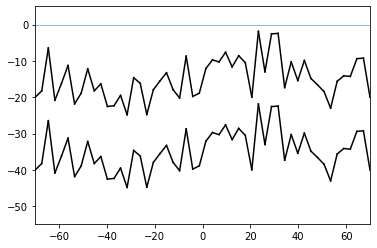

In [69]:
draw(points,MAP,R = 70)

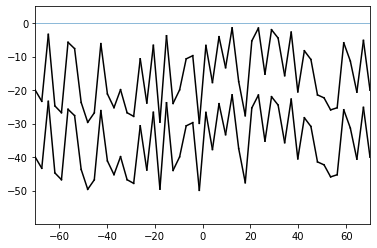

In [71]:
draw(points,True_position,R=70)

In [65]:
True_position

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([ -5.1785946, -20.606672 , -11.302174 ,  -5.881212 , -25.273802 ,
       -25.910046 , -22.322052 , -21.430578 , -10.866999 ,  -8.264807 ,
       -20.506378 ,  -2.7172203, -15.685033 ,  -4.4548607,  -1.9767189,
       -15.243669 ,  -1.4924355,  -5.306797 , -27.638058 , -17.484085 ,
        -1.4281998, -13.29978  ,  -4.0646133, -17.730865 ,  -6.6842613,
       -29.919191 ,  -9.722929 , -10.675497 , -19.930891 , -23.981983 ,
        -3.7785053, -29.56805  ,  -6.642231 , -23.847294 , -10.673523 ,
       -27.841599 , -26.760345 , -19.875717 , -25.240387 , -21.150068 ,
        -6.138069 , -26.8024   , -29.624378 , -23.675385 ,  -7.6183796,
        -5.7310066, -26.752445 , -24.728394 ,  -3.3791924, -23.340313 ],
      dtype=float32)>

### Random Walk MCMC

In [72]:
num_results = 10
burnin = 0

initial_chain_state = [
    -10 * tf.ones([Number_para], dtype=tf.float32, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(D,points,*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float32

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [73]:
accept_index = np.where(accepted==True)
accepted_samples = samples[accept_index]

In [74]:
accepted_samples.shape[0]/num_results

0.5

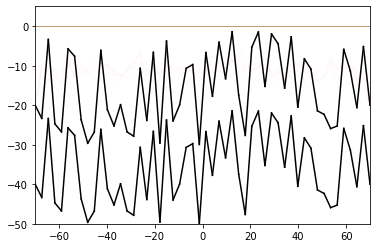

In [75]:
draw_MCMC(points,accepted_samples[:,:,0],Truth=True_position) # [:,:,0] transpost the results for plotting

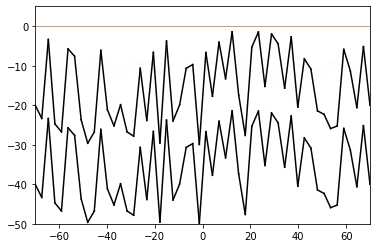

In [76]:
draw_MCMC(points,accepted_samples[0:2,:,0],Truth=True_position)

In [33]:
points

<tf.Variable 'Variable:0' shape=(14, 2) dtype=float32, numpy=
array([[-200.      ,  -40.      ],
       [ -70.      ,  -40.      ],
       [ -35.      ,  -39.212463],
       [   0.      ,  -38.33638 ],
       [  35.      ,  -34.293606],
       [  70.      ,  -40.      ],
       [ 200.      ,  -40.      ],
       [ 200.      ,  -20.      ],
       [  70.      ,  -20.      ],
       [  35.      ,  -14.293606],
       [   0.      ,  -18.336382],
       [ -35.      ,  -19.212463],
       [ -70.      ,  -20.      ],
       [-200.      ,  -20.      ]], dtype=float32)>

In [54]:
True_position

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ -5.1785946, -20.606672 , -11.302174 ], dtype=float32)>

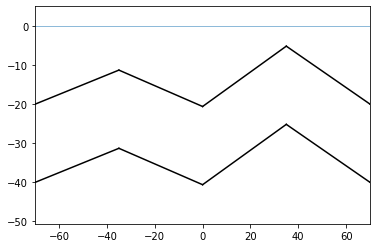

In [35]:
draw(points,True_position,R=70)

# Hessian Method

In [38]:
with tf.GradientTape() as t:  
    t.watch(points)
    loss = tf.negative(joint_log_prob(D,points,MAP)) # negative log posterior
    dlossdmu = t.gradient(loss,points)
    print(dlossdmu)

tf.Tensor(
[[ 0.04491242  0.01316353]
 [-0.0053577   0.0583462 ]
 [-0.00584992  0.02409294]
 [-0.00113579 -0.04252679]
 [ 0.01301334  0.01967661]
 [ 0.00912798  0.05072638]
 [-0.04591475  0.01091762]
 [ 0.04491242 -0.00728843]
 [-0.0223182  -0.08244012]
 [-0.04054962 -0.09202901]
 [-0.01056352  0.1373597 ]
 [ 0.01582097 -0.07725944]
 [ 0.01163589 -0.08546148]
 [-0.04371582 -0.0087679 ]], shape=(14, 2), dtype=float32)


In [77]:
with tf.GradientTape() as t:
    with tf.GradientTape() as tt:
        tt.watch(points)
        loss = tf.negative(joint_log_prob(D,points,MAP))
    jac = tt.gradient(loss,points)
hess = t.jacobian(jac,points)

KeyboardInterrupt: 

In [40]:
print(hess)

tf.Tensor(
[[[[ 6.40909791e-01  8.71179998e-02]
   [-2.67109200e-02  3.03733915e-01]
   [ 4.21840698e-04  3.31570625e-01]
   [-2.88295709e-02  3.70260924e-01]
   [-6.09306013e-03  3.49520862e-01]
   [ 5.04545718e-02  3.06818187e-01]
   [-6.50966883e-01  8.70167091e-02]
   [ 6.40640140e-01 -5.00468463e-02]
   [-6.17419668e-02 -2.82925338e-01]
   [ 4.84523736e-03 -4.56661701e-01]
   [ 3.82574648e-02 -4.69223678e-01]
   [ 1.61077827e-04 -4.29877430e-01]
   [ 3.20324302e-02 -2.76228487e-01]
   [-6.30583048e-01 -5.00468276e-02]]

  [[ 8.71179998e-02  1.49788484e-02]
   [-4.73164720e-03  5.61065935e-02]
   [-7.58800248e-04  5.53234294e-02]
   [-2.51848786e-03  4.74364497e-02]
   [-1.42487662e-03  3.43465395e-02]
   [ 4.62728366e-03  2.93406900e-02]
   [-8.81872997e-02  9.17496346e-03]
   [ 8.70167315e-02 -5.09153539e-03]
   [-4.67644492e-03 -2.32761949e-02]
   [ 1.81212579e-03 -3.83428298e-02]
   [ 2.58851610e-03 -5.76060116e-02]
   [ 1.95259007e-03 -7.82641843e-02]
   [ 6.98353816e-03 -5.78

In [ ]:
HessMatrix = np.empty(shape = [Number_para,Number_para])
for x,i1 in enumerate(range(Number_para+6,2*Number_para+6)):
    for y,i2 in enumerate(range(Number_para+6,2*Number_para+6)):
        HessMatrix[x,y] = hess[i1,1,i2,1]

In [ ]:
print(HessMatrix)

In [ ]:
def Laplace_appro(H,C_prior):
    return tf.linalg.inv((tf.add(H,tf.linalg.inv(C_prior))))


In [ ]:
cov_post = Laplace_appro(HessMatrix,cov_prior)

In [100]:
cov_post

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 2.2091596, -1.6563011,  0.5120193],
       [-1.656301 ,  4.037153 , -1.9677684],
       [ 0.5120189, -1.9677678,  2.8830686]], dtype=float32)>

In [101]:
@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float32)
    matrix2 = tf.cast(matrix2,tf.float32)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

def acceptance_gpCN(m_current , m_proposed):
    delta_current = tf.subtract(negative_log_post(m_current),matrixcompute(m_current,MAP,cov_post))
    delta_proposed = tf.subtract(negative_log_post(m_proposed),matrixcompute(m_proposed,MAP,cov_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False
        
from IPython.display import clear_output
# define leaning rate
beta = 0.4

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(tf.sqrt(1-beta**2),dtype = tf.float32)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= cov_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed       

In [102]:
draw_proposal(MAP)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ -6.25108 , -18.79881 , -11.842674], dtype=float32)>

In [ ]:
def negative_log_post(mu):
    return(tf.negative(joint_log_prob(D,points,mu)))

In [104]:
mu_init = -10 * tf.ones([Number_para], dtype=tf.float32)

number_of_steps = 2000
def run_chain():
    burn_in = 1000
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted = np.array(accepted)



Acceptance rate = 0.0%


gpCN seems not quite correct, the reason is demonstrated below in DEBUG:

-  the main reason it's failed is the acceptence rate: negative log post minus the diff in $m_v$ makes the good proposal have big $\Delta$

let's try pCN first

In [105]:
cov_post

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 2.2091596, -1.6563011,  0.5120193],
       [-1.656301 ,  4.037153 , -1.9677684],
       [ 0.5120189, -1.9677678,  2.8830686]], dtype=float32)>

In [58]:
cov_prior

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[20.,  0.,  0.],
       [ 0., 20.,  0.],
       [ 0.,  0., 20.]], dtype=float32)>

### try pCN MCMC

first define a likelihood function rather than posteior function

In [ ]:
def likelihood(D,points_copy,ps):

    Gm_ = grav(points_copy,ps)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm_,
            covariance_matrix= cov)
    
    return mvn_likelihood.log_prob(D)

def negative_likeli(D,points,ps):
    return tf.negative(likelihood(D,points,ps))

In [164]:
negative_likeli(D,points,m_test)

<tf.Tensor: shape=(), dtype=float32, numpy=-113.3639>

In [165]:
def acceptance_pCN(m_current , m_proposed):
    delta_current = negative_likeli(D,points,m_current)
    delta_proposed = negative_likeli(D,points,m_proposed)
    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False

In [ ]:
mu_init = -10 * tf.ones([Number_para], dtype=tf.float32)

number_of_steps = 2000
def run_chain():
    burn_in = 1000
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        if acceptance_pCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted = np.array(accepted)

### Debug|

In [ ]:
mu_init = [-2.,-2.,-4.]

number_of_steps = 10

burn_in = 5
steps = number_of_steps
k = 0
accepted = []
rejected = []

m_current = mu_init  # init m
    
    
for k in range(steps+burn_in):

    m_proposed = draw_proposal(m_current)

    if acceptance_gpCN(m_current,m_proposed):
        m_current = m_proposed
        if k > burn_in:
            accepted.append(m_proposed.numpy())
    else:
        m_current = m_current
        rejected.append(m_proposed.numpy())
    


In [106]:
MAP

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ -6.1381764, -18.831266 , -12.485522 ], dtype=float32)>

In [117]:
m1 = draw_proposal(MAP)

In [122]:
m_test = tf.constant([-1.,-10.,-2.])

In [123]:
acceptance_gpCN(MAP,m_test)

True

In [119]:
def acceptance_pCN(m_current , m_proposed):
    delta_current = tf.subtract(negative_log_post(m_current),matrixcompute(m_current,MAP,cov_post))
    delta_proposed = tf.subtract(negative_log_post(m_proposed),matrixcompute(m_proposed,MAP,cov_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False

In [155]:
negative_log_post(MAP)

<tf.Tensor: shape=(), dtype=float32, numpy=-108.65752>

In [156]:
negative_log_post(m_test)

<tf.Tensor: shape=(), dtype=float32, numpy=-86.48848>

In [146]:
m_current =  m_test
m_proposed = MAP

delta_current = tf.subtract(negative_log_post(m_current),matrixcompute(m_current,MAP,cov_post))
delta_proposed = tf.subtract(negative_log_post(m_proposed),matrixcompute(m_proposed,MAP,cov_post))
accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))

In [157]:
delta_current

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-193.98718]], dtype=float32)>

In [158]:
delta_proposed

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-108.65752]], dtype=float32)>